In [2]:
!pip install tensorflow==2.4.1 opencv-python mediapipe sklearn matplotlib

  Using cached tensorflow-2.4.1-cp38-cp38-macosx_10_11_x86_64.whl (173.9 MB)
  Using cached opencv_python-4.5.5.64-cp36-abi3-macosx_10_15_x86_64.whl (46.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 1.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Using cached matplotlib-3.5.2-cp38-cp38-macosx_10_9_x86_64.whl (7.3 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached numpy-1.19.5-cp38-cp38-macosx_10_9_x86_64.whl (15.6 MB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Preparing metadata (setup.py) ... done
  Using cached protobuf-3.20.1-cp38-cp38-macosx_10_9_x86_64.whl (962 kB)
  Using cached tensorboard-2.9.0-py3-

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [4]:
mp_holistic = mp.solutions.holistic #Holistic model
mp_drawing = mp.solutions.drawing_utils #drawing utilities

In [12]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)#color conversion bgr t0 rgb
    image.flags.writeable = False #image is no longer writeable
    results = model.process(image) #make prediction
    image.flags.writeable = True # image is now writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) #color conversion rgb to bgr
    return image,results

In [15]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)#draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)#draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)#draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)#draw right hand connections
                

In [20]:
def draw_styled_landmarks(image,results):
    #draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)
                             )
    
    #draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=2)
                             )
      
    #draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250),thickness=2,circle_radius=2)
                             )
    
    #draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2)
                             )
                

In [42]:
cap = cv2.VideoCapture(0)
#access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        
        #read feed
        ret,frame = cap.read()
        
        #make predictions
        image,results = mediapipe_detection(frame,holistic)
        print(results)
        
        #draw landmarks
        draw_styled_landmarks(image,results)
        
        #show to screen
        cv2.imshow('action',image)
        
        #break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [26]:
len(results.pose_landmarks.landmark)

33

In [28]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x,res.y,res.z,res.visibility])
    pose.append(test)

In [31]:
pose

[array([ 0.53245223,  0.38332969, -1.07678962,  0.99994761]),
 array([ 0.55267918,  0.28563944, -1.019135  ,  0.99988002]),
 array([ 0.56783628,  0.28607142, -1.01911175,  0.99989522]),
 array([ 0.58242494,  0.28695202, -1.01906931,  0.99986202]),
 array([ 0.50174582,  0.29142034, -1.0267086 ,  0.99989241]),
 array([ 0.484584  ,  0.29583085, -1.02598453,  0.9999097 ]),
 array([ 0.46882996,  0.3007583 , -1.02631021,  0.99989873]),
 array([ 0.59710294,  0.32830483, -0.62401021,  0.99982846]),
 array([ 0.44133291,  0.34301579, -0.65979373,  0.99993759]),
 array([ 0.56423169,  0.46846026, -0.92720366,  0.99993253]),
 array([ 0.49878231,  0.47251019, -0.93572122,  0.99995971]),
 array([ 0.7475    ,  0.77418864, -0.37390822,  0.9987945 ]),
 array([ 0.29689646,  0.80207628, -0.43309587,  0.99928147]),
 array([ 0.82580853,  1.34506249, -0.47346243,  0.14370134]),
 array([ 0.18630545,  1.37602043, -0.47264075,  0.38196054]),
 array([ 0.82824212,  1.57760727, -1.01588535,  0.05760959]),
 array([

In [45]:
pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)


In [47]:
face

array([ 0.81580305,  0.55668074, -0.03203377, ...,  0.90449858,
        0.44078952,  0.02715585])

In [34]:
pose

array([ 5.32452226e-01,  3.83329690e-01, -1.07678962e+00,  9.99947608e-01,
        5.52679181e-01,  2.85639435e-01, -1.01913500e+00,  9.99880016e-01,
        5.67836285e-01,  2.86071420e-01, -1.01911175e+00,  9.99895215e-01,
        5.82424939e-01,  2.86952019e-01, -1.01906931e+00,  9.99862015e-01,
        5.01745820e-01,  2.91420341e-01, -1.02670860e+00,  9.99892414e-01,
        4.84584004e-01,  2.95830846e-01, -1.02598453e+00,  9.99909699e-01,
        4.68829960e-01,  3.00758302e-01, -1.02631021e+00,  9.99898732e-01,
        5.97102940e-01,  3.28304827e-01, -6.24010205e-01,  9.99828458e-01,
        4.41332906e-01,  3.43015790e-01, -6.59793735e-01,  9.99937594e-01,
        5.64231694e-01,  4.68460262e-01, -9.27203655e-01,  9.99932528e-01,
        4.98782307e-01,  4.72510189e-01, -9.35721219e-01,  9.99959707e-01,
        7.47500002e-01,  7.74188638e-01, -3.73908222e-01,  9.98794496e-01,
        2.96896458e-01,  8.02076280e-01, -4.33095872e-01,  9.99281466e-01,
        8.25808525e-01,  

In [48]:
lh

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [49]:
rh

array([ 3.34652007e-01,  7.22001851e-01,  7.51291282e-07,  4.04126287e-01,
        6.91115975e-01, -3.41656879e-02,  4.62586701e-01,  6.12973273e-01,
       -5.11310026e-02,  5.06947160e-01,  5.38657129e-01, -6.58589080e-02,
        5.54289937e-01,  5.19796014e-01, -8.02765191e-02,  4.30197567e-01,
        4.17138636e-01, -1.93413682e-02,  4.57265973e-01,  3.07686120e-01,
       -3.52763832e-02,  4.71285194e-01,  2.36105323e-01, -5.05069196e-02,
        4.82401073e-01,  1.77362949e-01, -6.27013147e-02,  3.87476206e-01,
        3.91702741e-01, -1.88357923e-02,  4.02058542e-01,  2.62379229e-01,
       -3.25463898e-02,  4.09028143e-01,  1.78855509e-01, -4.73402664e-02,
        4.15636659e-01,  1.05670989e-01, -5.82983494e-02,  3.44162971e-01,
        3.99259806e-01, -2.31353827e-02,  3.44710290e-01,  2.74706185e-01,
       -4.19679955e-02,  3.47805977e-01,  1.94148928e-01, -5.88929132e-02,
        3.52817655e-01,  1.24279708e-01, -6.98900968e-02,  2.97820330e-01,
        4.36727166e-01, -

In [50]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])


In [52]:
extract_keypoints(results).shape

(1662,)

In [53]:
#path for exported data, numpy array
DATA_PATH = os.path.join('MP_data')

#actions that we try to detect
actions = np.array(['hello','thankyou','iloveyou'])

#thirty videos worth of data
no_sequences = 30

#videos are going to be thirty frames in length
sequence_length = 30

In [58]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass

In [59]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                #print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [60]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [61]:
label_map = {label:num for num,label in enumerate(actions)}

In [62]:
label_map

{'hello': 0, 'thankyou': 1, 'iloveyou': 2}

In [63]:
sequences,labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [90]:
os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(12))

'MP_data/iloveyou/29/12.npy'

In [89]:
np.array(sequences).shape

(90, 30, 1662)

In [66]:
np.array(labels).shape

(90,)

In [67]:
X = np.array(sequences)

In [68]:
y = to_categorical(labels).astype(int)

In [69]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [70]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05)

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [72]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

2022-05-18 04:01:27.076811: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-05-18 04:01:27.076849: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-05-18 04:01:27.076924: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [73]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

2022-05-18 04:02:33.884284: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-18 04:02:33.884724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [75]:
model.compile(optimizer = 'Adam',loss = 'categorical_Crossentropy',metrics = ['categorical_accuracy'])

In [91]:
model.load_weights('action.h5')

In [92]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [93]:
yhat = model.predict(X_test)

In [94]:
ytrue = np.argmax(y_test,axis=1).tolist()
yhat = np.argmax(yhat,axis=1).tolist()

In [95]:
yhat

[2, 0, 2, 0, 2]

In [96]:
ytrue

[2, 0, 2, 0, 2]

In [97]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[3, 0],
        [0, 2]],

       [[2, 0],
        [0, 3]]])

In [98]:
accuracy_score(ytrue,yhat)

1.0

In [103]:
#1. New detection variables
sequence = []
sentence = []
threshold = 0.7


cap = cv2.VideoCapture(0)
#access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        
        #read feed
        ret,frame = cap.read()
        
        #make predictions
        image,results = mediapipe_detection(frame,holistic)
        print(results)
        
        #draw landmarks
        draw_styled_landmarks(image,results)
        
        
        #prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
  #      sequence.append(keypoints)
        sequence = sequence[:30]
        
        if len(sequence)==30:
            res = model.predict(np.expand_dims(sequence,axis=0))[0]
            print(actions[np.argmax(res)])
            
        #viz logic
        if res[np.argmax(res)] > threshold:
            if len(sentence) >0:
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])
            
        if len(sentence) >5:
            sentence = sentence[-5:]
                
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
                    
        
        #show to screen
        cv2.imshow('action',image)
        
        #break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [104]:
from scipy import stats


In [105]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

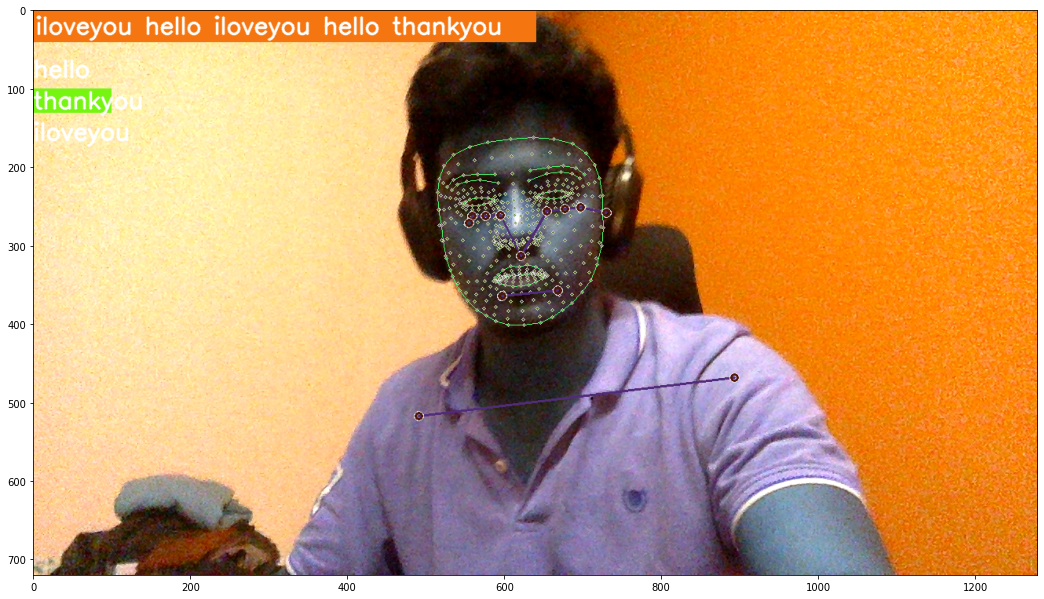

In [108]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [107]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<cla

iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<

<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thankyou
<class 'me

<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'me

<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'

<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'

iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
iloveyou
<